In [2]:
import numpy as np
from scipy import integrate
import scipy.special as special
from functools import reduce
from mpl_toolkits import mplot3d
import math
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
odeint = integrate.odeint
%matplotlib notebook
    

<IPython.core.display.Javascript object>


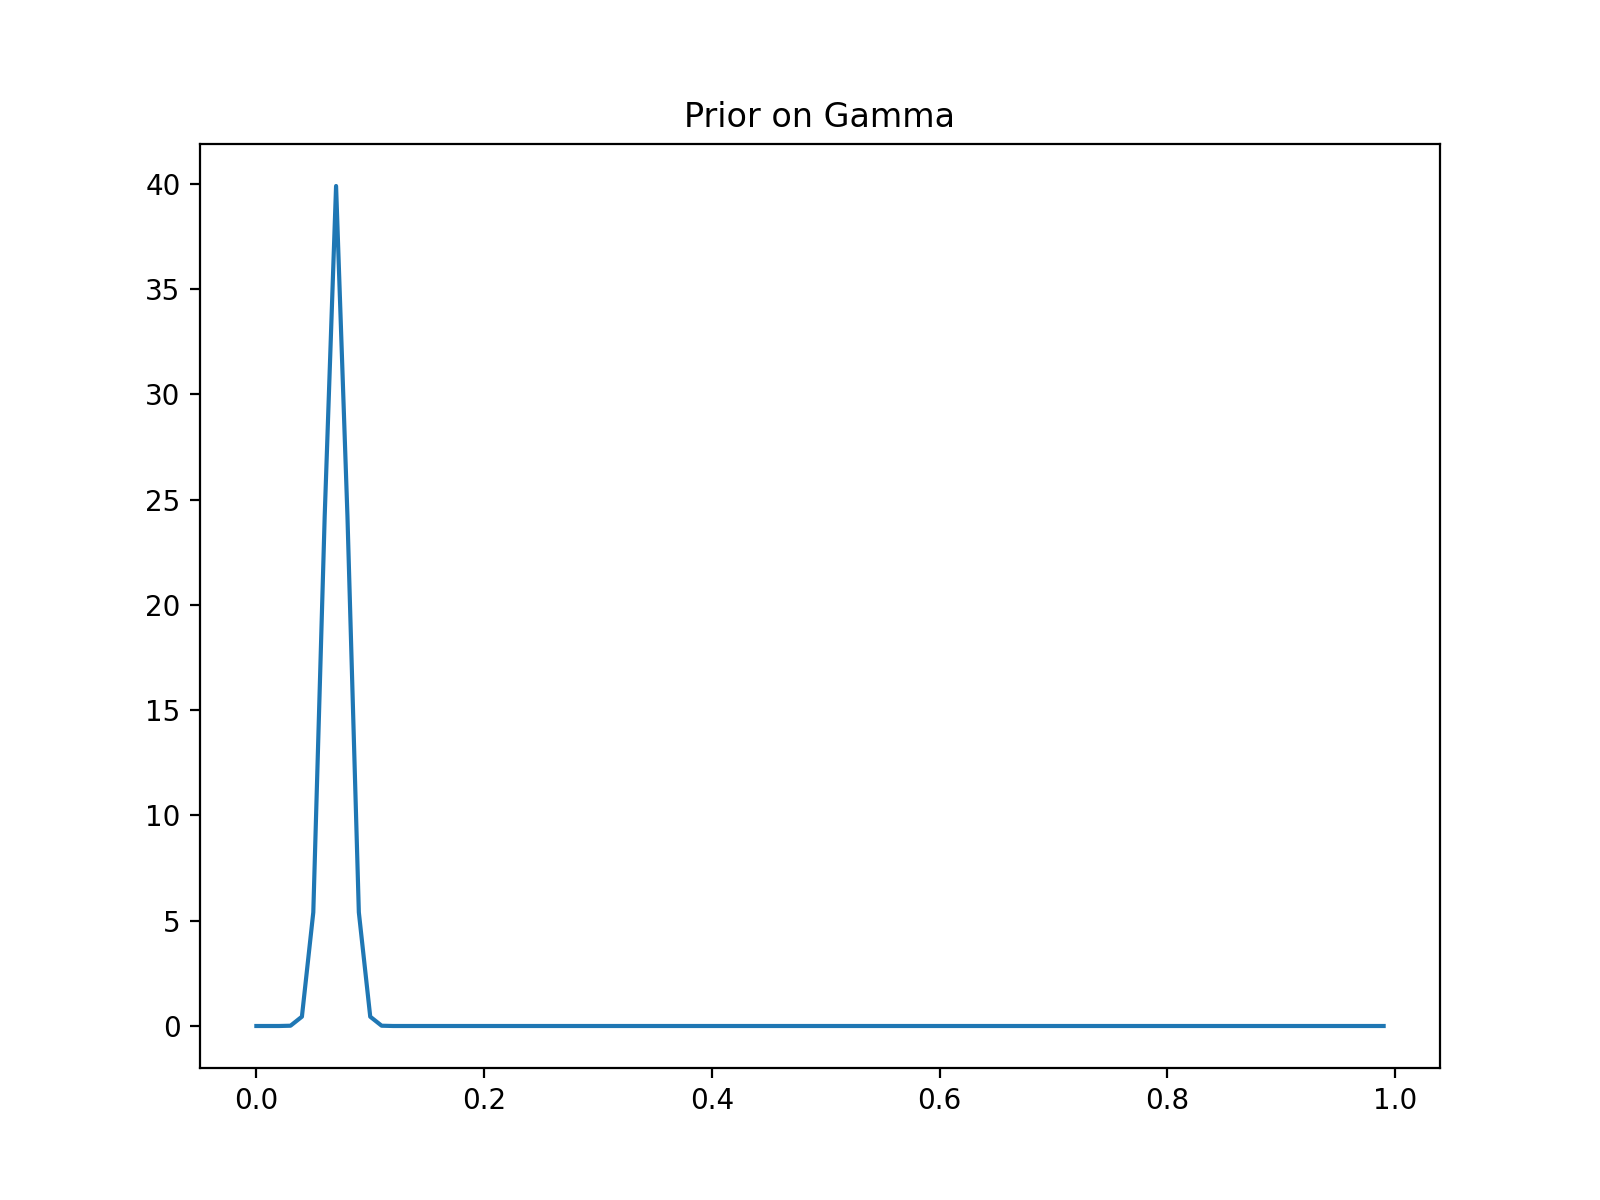

<IPython.core.display.Javascript object>


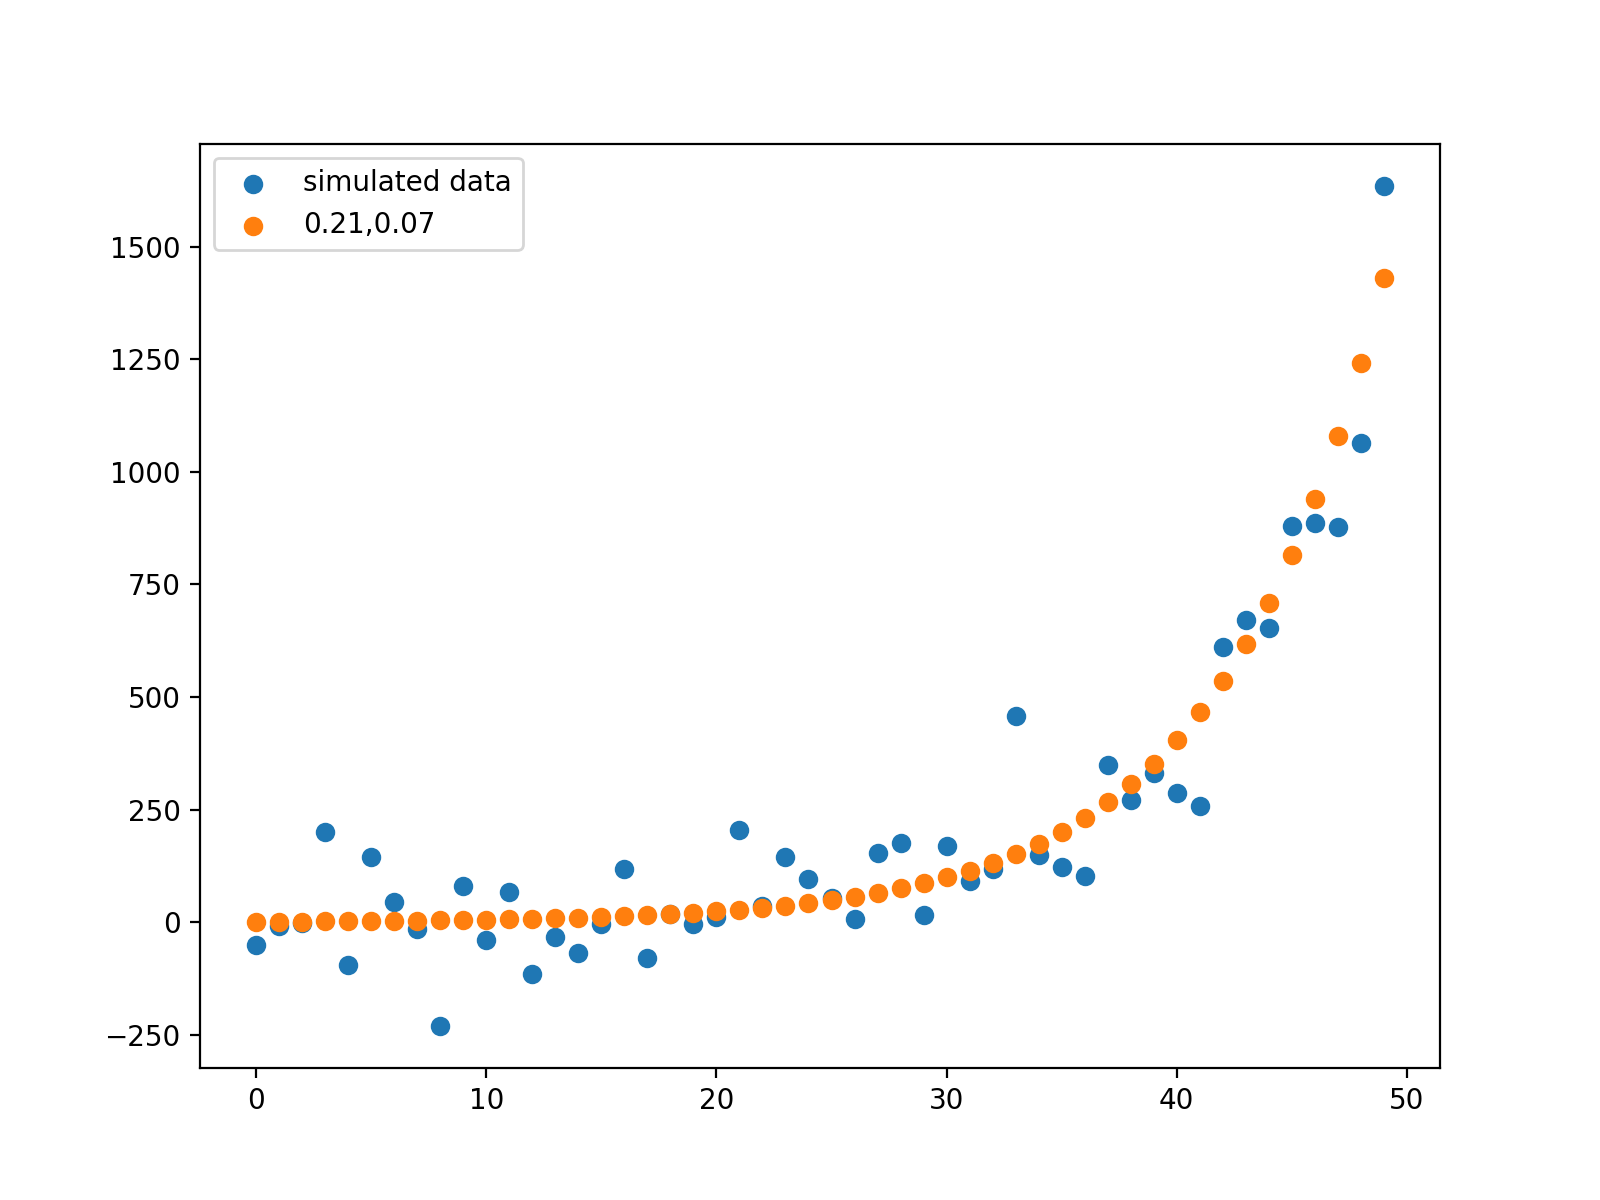

In [13]:
# Parameters
beta = 0.21
gamma = 0.07
sigma = 100
sig = 0.01
days = 50

# Generate simulated data using normal noise
def simData():
    X = []
    for t in range(days):
        x = beta/((beta-gamma))*(np.exp(t*(beta-gamma))-1)+1
        y = beta/((beta-gamma))*(np.exp((t-1)*(beta-gamma))-1)+1
        X.append(x+np.random.normal(0,sigma))
    return X 

# Generate simulated data using normal noise
def simDataI():
    X = []
    for t in range(days):
        X.append(np.exp(t*(beta-gamma))+np.random.normal(0,sigma))
    return X 

# Deterministic approximation for 1 - S
def determined(beta,gamma,t):
    if (beta-gamma)==0:
        return (beta*t+1)
    else:
        return (beta/((beta-gamma))*(np.exp(t*(beta-gamma))-1)+1)
    
# Deterministic approximation for I
def determinedI(beta,gamma,t):
    if (beta-gamma)==0:
        return (beta*t+1)
    else:
        return np.exp(t*(beta-gamma))

# Generate prior
# *** Here is where you set the priors for beta and gamma ***
def prior(step):
    # Prior for beta
    pB = betaPrior(step)
    pB = np.reshape(pB,(1,-1))
    # Prior for gamma
    pG = gammaPrior(step)
    pG = np.reshape(pG,(-1,1))
    return np.dot(pG,pB)

def logPrior(step):
    # Prior for beta
    pB = np.array(stats.uniform(0,1).logpdf(np.arange(0,1,step)))
    pB = np.reshape(pB,(1,-1))
    # Prior for gamma
    mu = 0.07
    pG = np.array(stats.truncnorm((0-mu)/sig, (5-mu)/sig, mu,sig).logpdf(np.arange(0,1,step)))
    pG = np.reshape(pG,(-1,1))
    return pG + pB

def gammaPrior(step):
    mu = 0.07
    return np.array(stats.truncnorm((0-mu)/sig, (5-mu)/sig, mu,sig).pdf(np.arange(0,1,step)))

def betaPrior(step):
    return np.array(stats.uniform(0,1).pdf(np.arange(0,1,step)))

def likelihood(step,X):
    likelihoods = []
    for t in range(len(X)):
        L = []
        for g in np.arange(0,1,step):
            row = []
            for b in np.arange(0,1,step):
                row.append(X[t]-determined(b,g,t))
            L.append(row)
        likelihoods.append(np.array(stats.norm(0,sigma).pdf(L)))
        
    likelihood = reduce(lambda x, y: np.multiply(x,y), likelihoods)
    return likelihood

    
def logLikelihood(step,X):
    likelihoods = []
    for t in range(len(X)):
        L = []
        for g in np.arange(0,1,step):
            row = []
            for b in np.arange(0,1,step):
                row.append(X[t]-determined(b,g,t))
            L.append(row)
        likelihoods.append(np.array(stats.norm(0,sigma).logpdf(L)))
        
    likelihood = reduce(lambda x, y: x+y, likelihoods)
    return likelihood

def logLikelihoodI(step,X):
    likelihoods = []
    for t in range(len(X)):
        L = []
        for g in np.arange(0,1,step):
            row = []
            for b in np.arange(0,1,step):
                row.append(X[t]-determinedI(b,g,t))
            L.append(row)
        likelihoods.append(np.array(stats.norm(0,sigma).logpdf(L)))
        
    likelihood = reduce(lambda x, y: x+y, likelihoods)
    return likelihood

# Generate posterior
def posterior(step,X):
    # Use below for MLE
    # return likelihood(step,X)
    # Use below for Bayesian
    return np.multiply(likelihood(step,X), prior(step))

def normal(z,step):
    i = step*reduce(lambda x, y: x+y, np.transpose(z))
    j = step*reduce(lambda x, y: x+y, i)
    z_n = z/j
    return j

def marginalPosteriors(z,step):
    gP = step*reduce(lambda x, y: x+y, np.transpose(z))
    bP = step*reduce(lambda x, y: x+y, z)
    return (bP, gP)

def marginalPosteriors2(X,step):
    bP = []
    for b in arange(0,1,step):
        l = 0
        for x in X:
            l = l + x + b*np.log(b)+(-np.log(b-1)+special.exp1(-b)-special.exp1(1-b))*b
    return (bP, gP)
    

def logPosterior(step,X):
    return logLikelihood(step,X) + logPrior(step)

def logPosteriorI(step,X):
    return logLikelihoodI(step,X) + logPrior(step)

def logPosteriorJoint(step,X,XI):
    return logLikelihoodI(step,XI) + logLikelihood(step,X) + logPrior(step)
    
data = simData()

# Plot of prior
fig, cx = plt.subplots(1, 1, figsize=(8,6), sharex=False)
cx.plot(np.arange(0,1,0.01),gammaPrior(0.01))
plt.title("Prior on Gamma")

# Plot of data
steps = days
T = np.linspace(0,days-1,steps)
fig, ax = plt.subplots(1, 1, figsize=(8,6), sharex=False)
ax.scatter(T,data, label="simulated data")

def plotCurve(beta,gamma):
    curve = []
    for t in range(days):
        curve.append(determined(beta,gamma,t))
    return curve


#ax.plot(T,plotCurve(0.2,0.1),label = "0.2,0.1")
#ax.plot(T,plotCurve(0.14,0.07),label = "0.14,0.07")
ax.scatter(T,plotCurve(0.21,0.07),label = "0.21,0.07")
ax.legend(loc="best")
 




In [14]:
# Functions for individual likelihoods (no grid)
def indivLikelihood(b,g,X):
    array = []
    for t in range(len(X)):
        array.append(X[t]-determined(b,g,t))
        
    likelihoods = np.array(stats.norm(0,sigma).pdf(array))
    likelihood = reduce(lambda x, y: np.multiply(x,y), likelihoods)
    return likelihood

def indivLogLikelihood(b,g,X):
    array = []
    for t in range(len(X)):
        array.append(X[t]-determined(b,g,t))
        
    likelihoods = np.array(stats.norm(0,sigma).logpdf(array))
    likelihood = reduce(lambda x, y: x+y, likelihoods)
    return likelihood

def indivLogPrior(g):
    mu = 0.07
    return stats.truncnorm((0-mu)/sig, (5-mu)/sig, mu,sig).logpdf(g)

def indivLogPosterior(b,g,X):
    return indivLogPrior(g) + indivLogLikelihood(b,g,X)





-7.920420833320471e+37
Highest density: -301.4134486104
Parameters (beta,gamma) with highest density:
(0.21,0.07)


<IPython.core.display.Javascript object>


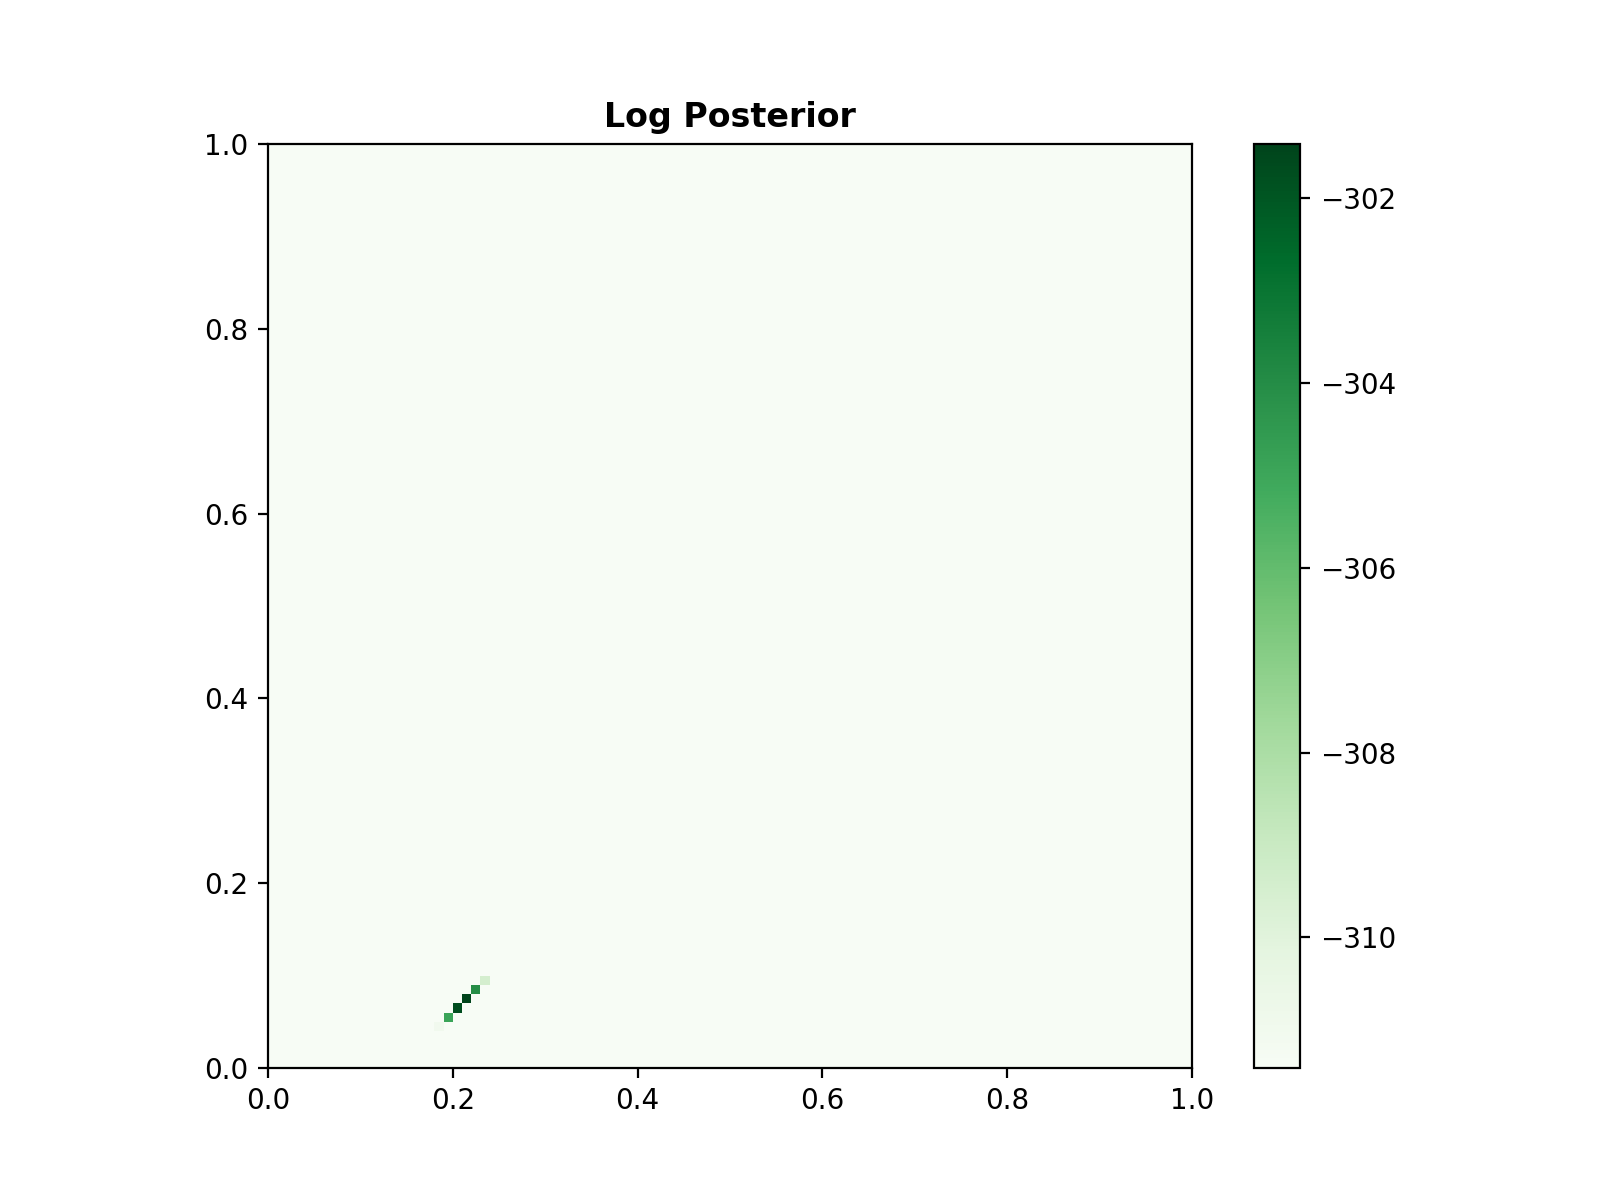

0.0


<IPython.core.display.Javascript object>


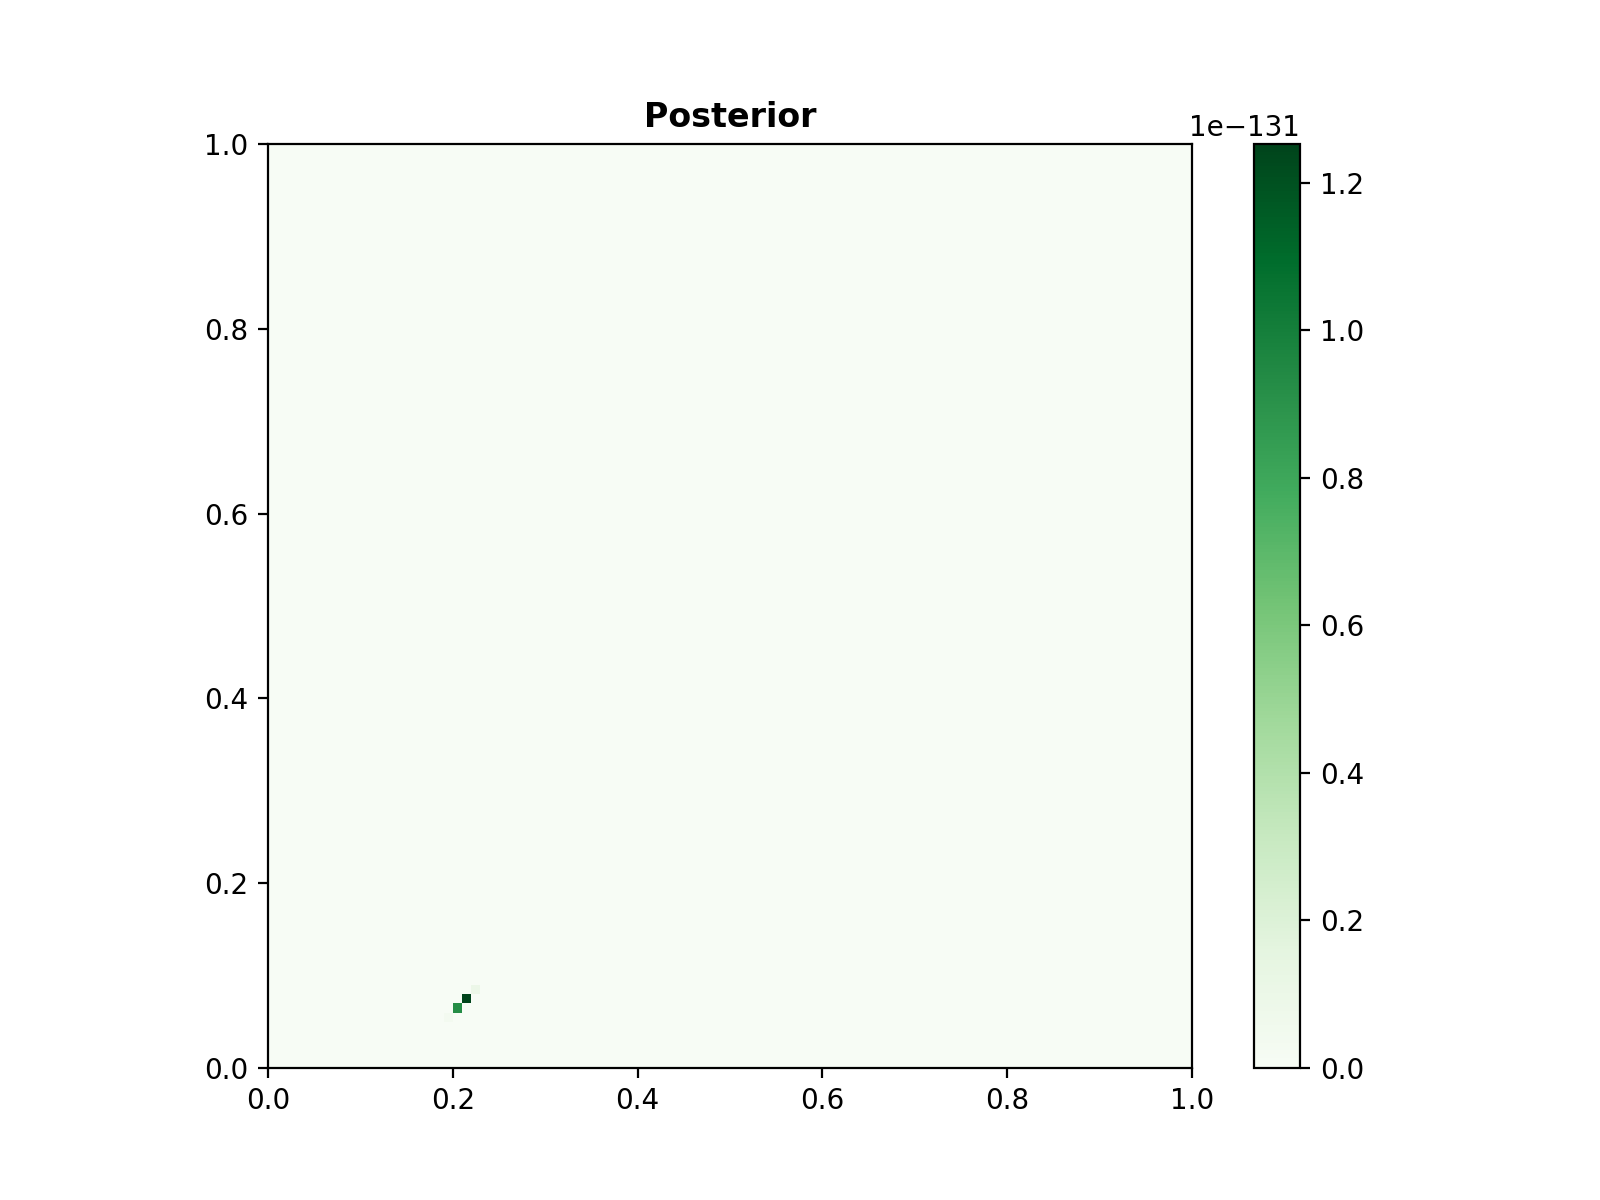

In [15]:
#Plot parameters
stepSize = 0.01
minBeta, maxBeta = 0,1
minGamma, maxGamma = 0,1

# Plot log posterior
z = logPosterior(stepSize,data)

arr = np.array(z)
z_min, z_max = np.amin(arr), np.amax(arr)
print(z_min)
print('Highest density: ' + str(np.amax(arr)))
result = np.where(arr == np.amax(arr))
print('Parameters (beta,gamma) with highest density:')
print('(' + str(result[1][0]*stepSize)+','+str(result[0][0]*stepSize)+')')

fig, bx = plt.subplots(1, 1, figsize=(8,6), sharex=False)
threshold = 10
c = bx.imshow(z, cmap ='Greens', vmin = z_max-threshold, vmax = z_max,
                 extent =[0, 1, 0, 1],
                    interpolation ='nearest', origin ='lower')
plt.colorbar(c)
  
plt.title('Log Posterior', fontweight ="bold")

plt.show()

# Plot posterior
#z = posterior(stepSize,data)
z = np.exp(z)
print(z[50,24])
arr = np.array(z)
z_min, z_max = np.amin(arr), np.amax(arr)
fig, dx = plt.subplots(1, 1, figsize=(8,6), sharex=False)
d = dx.imshow(z, cmap ='Greens', vmin = 0, vmax = z_max,
                 extent =[0, 1, 0, 1],
                    interpolation ='nearest', origin ='lower')
plt.colorbar(d)
  
plt.title('Posterior', fontweight ="bold")

plt.show()

# l = z[::2]
# z2 = []
# for x in l:
#     z2.append(x[::2])
    
# fig, zx = plt.subplots(1, 1, figsize=(8,6), sharex=False)
# d = zx.imshow(z2, cmap ='Greens', vmin = 0, vmax = z_max,
#                  extent =[0, 1, 0, 1],
#                     interpolation ='nearest', origin ='lower')
# plt.colorbar(d)
  
# plt.title('Posterior', fontweight ="bold")

# plt.show()


In [16]:
print(z[18][31])

2.7280593546873223e-158


<IPython.core.display.Javascript object>


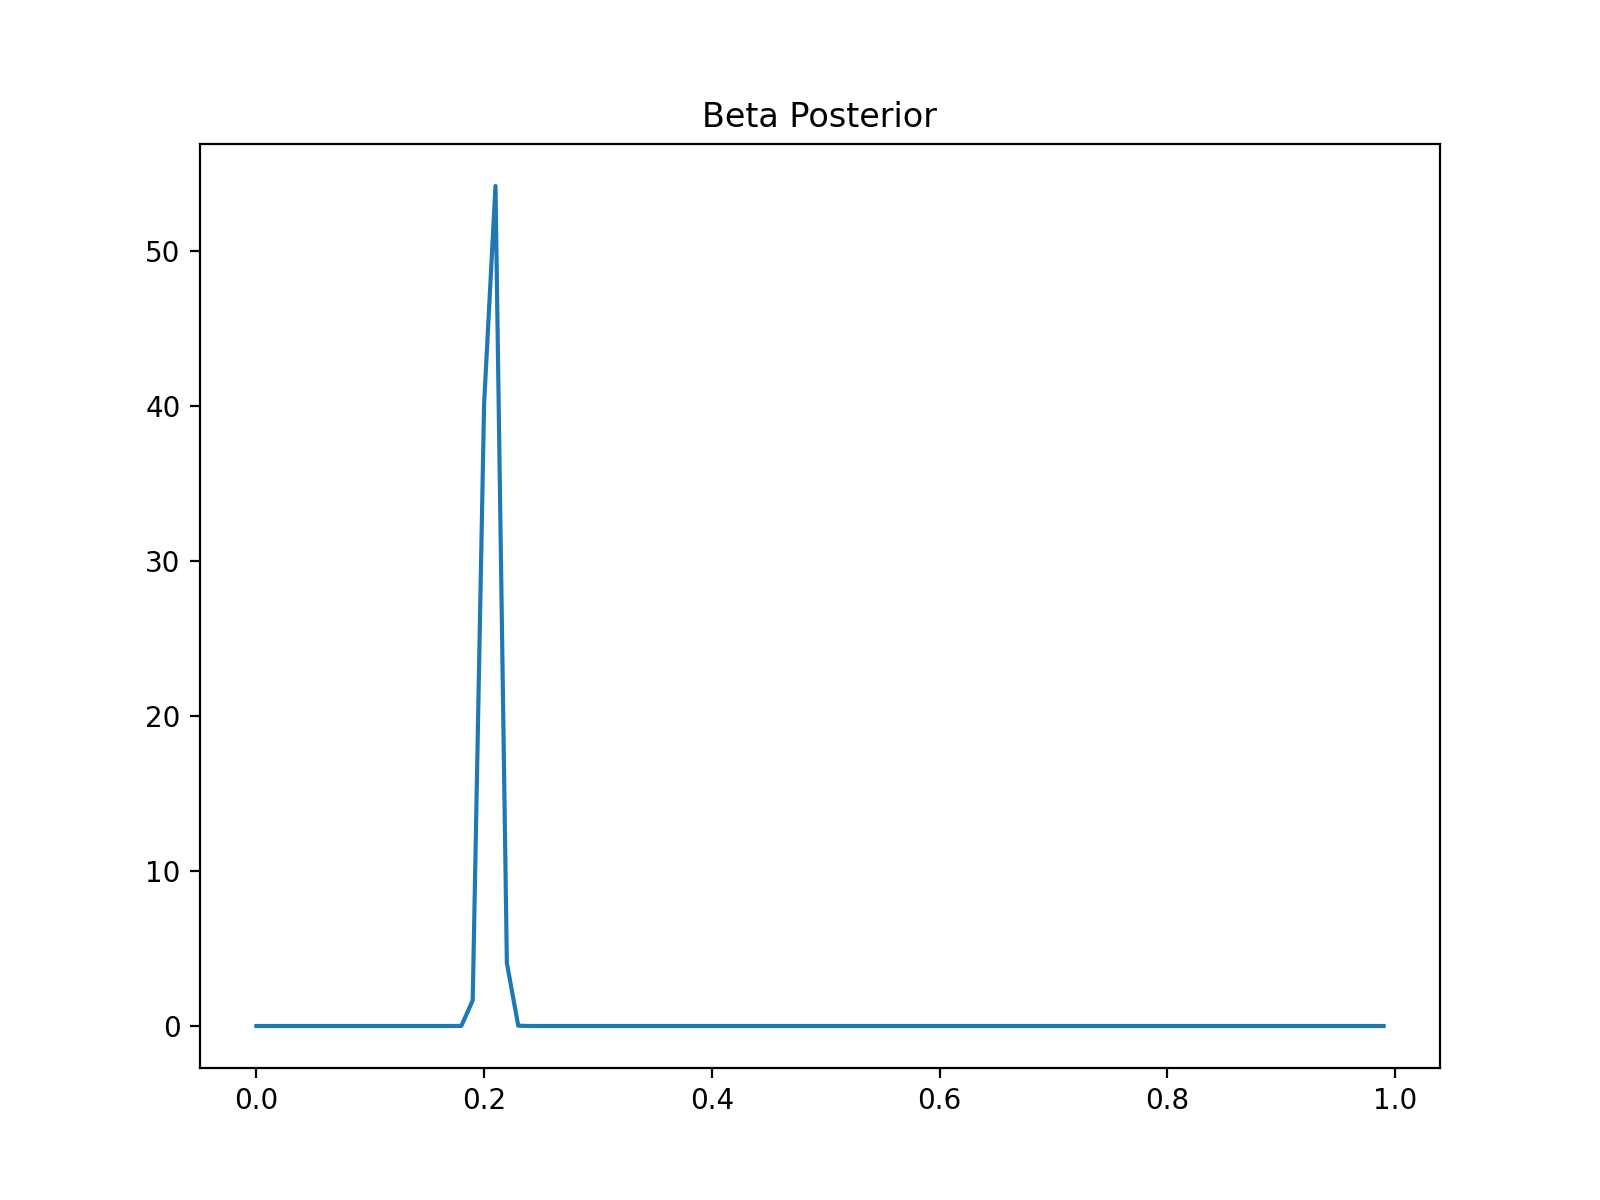

<IPython.core.display.Javascript object>


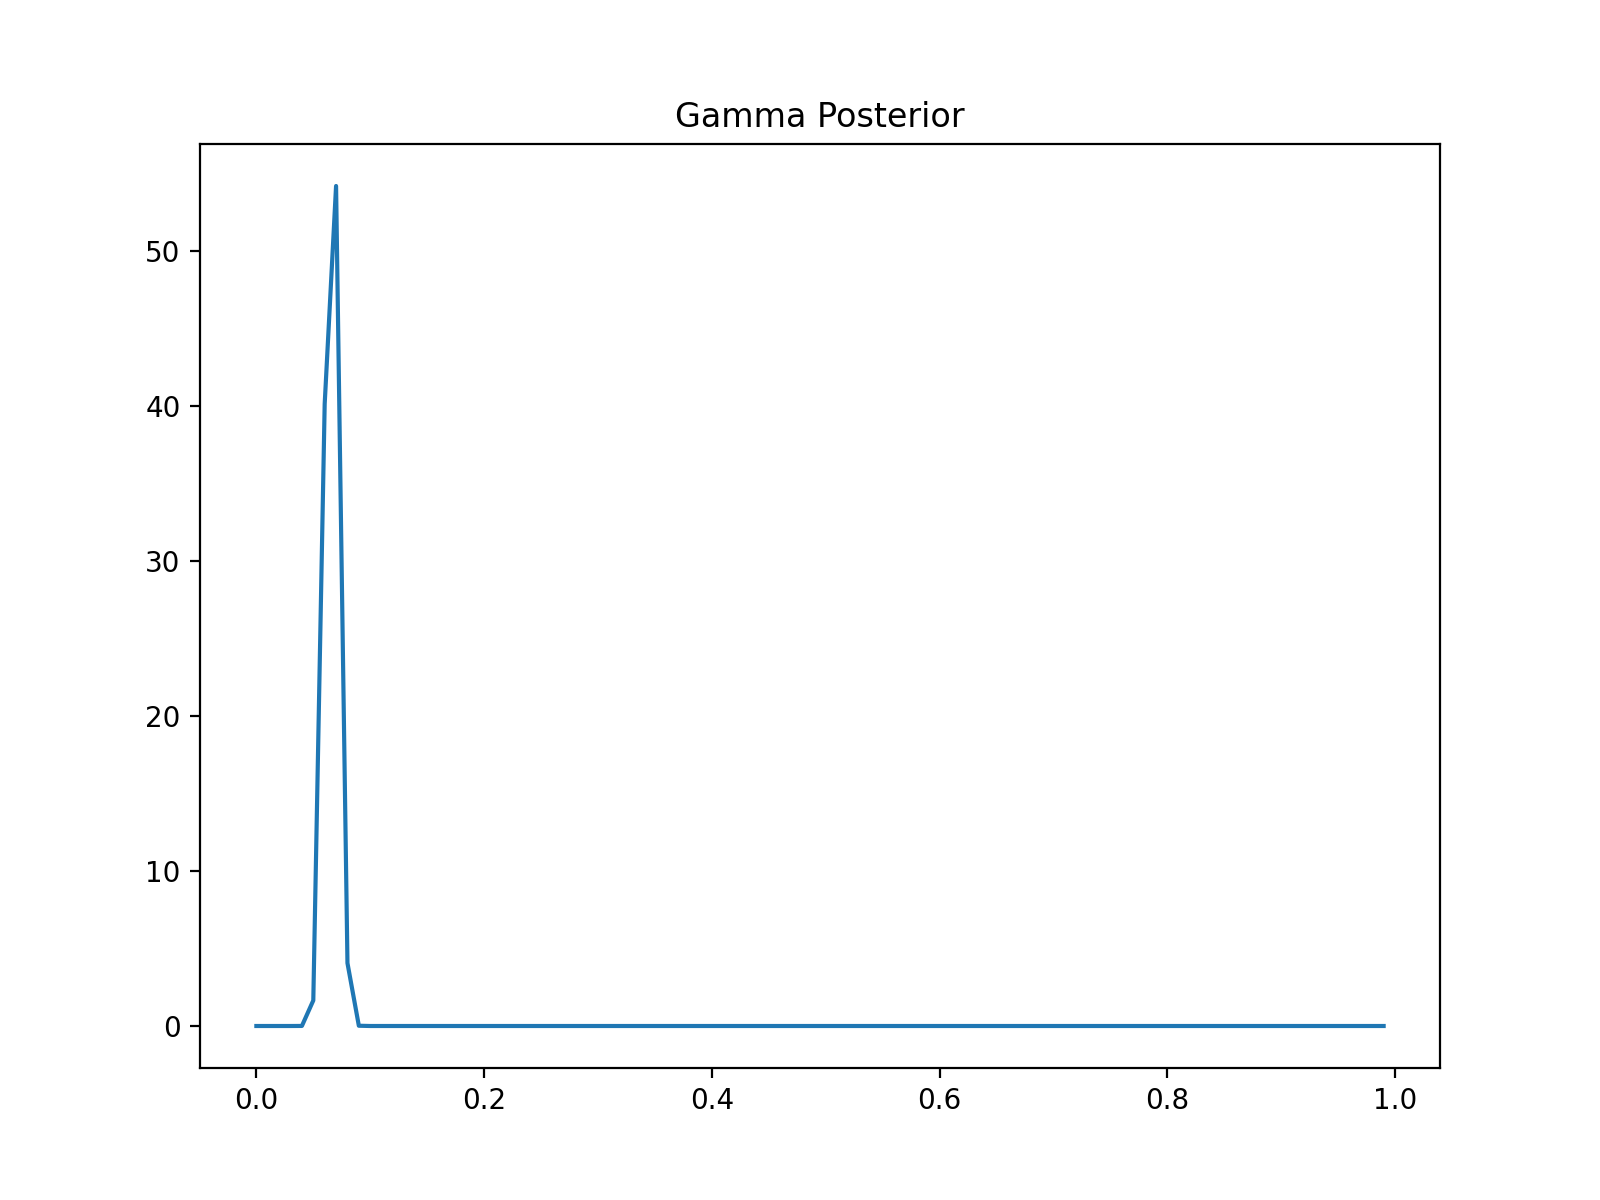

Text(0.5, 1.0, 'Gamma Posterior')

In [17]:
# Find normalizing constant
z_n = z/normal(z,stepSize)

# Plot marginal posteriors
bPost, gPost = marginalPosteriors(z_n, stepSize)
fig, ex = plt.subplots(1, 1, figsize=(8,6), sharex=False)
ex.plot(np.arange(0,1,stepSize),bPost)
plt.title("Beta Posterior")
fig, fx = plt.subplots(1, 1, figsize=(8,6), sharex=False)
fx.plot(np.arange(0,1,stepSize),gPost)
plt.title("Gamma Posterior")

In [200]:
### Gradient ascent X[t]
def gradient(b,g,X):
    l_b = 0
    for t in range(len(X)):
        #l_b = l_b - (b*np.exp(t*(b-g))-X[t]*b+g*X[t]-g)*((t*b**2-g*t*b-g)*np.exp(t*(b-g))+g)/(b-g)**3
        l_b = l_b - (-(b*(np.exp(t*(b-g))-1))/(b-g)+X[t]-1)*(-(t*b*np.exp(t*(b-g)))/(b-g)-(np.exp(t*(b-g))-1)/(b-g)+(b*(np.exp(t*(b-g))-1))/(b-g)**2)/sigma**2
    
    l_g = 0
    for x in X:
        l_g = l_g - (-(b*(np.exp(t*(b-g))-1))/(b-g)+X[t]-1)*((b*t*np.exp(t*(b-g)))/(b-g)-(b*(np.exp(t*(b-g))-1))/(b-g)**2)/sigma**2
    #l_g = l_g - days*(g-gamma)/sig**2
    return (l_b,l_g) 

print(gradient(0,1,data))

def ascent(X, iterations):
    rate = 0.01
    b = 0.4
    g = 0.3
    for i in range(iterations):
        (l_b,l_g) = gradient(b,g,X)
        print(l_b,l_g)
        b = b + rate*l_b
        g = g + rate*l_g
        if b < 0:
            b = 0
        if b > 1:
            b=1
        if g < 0:
            g = 0
        if g> 1:
            g = 1
        print(b,g)
    
    return(b,g)

#print(ascent(data, 1000))

393.2432174384055 -2503.949778685208
0.21000000000000002 0.09000000000000001
500.02738515795244 -2943.4576177046088
0.22000000000000003 0.08000000000000002
89.48081061281793 2549.682195675395
0.23000000000000004 0.09000000000000001
5.533056366092367 3489.329975417227
0.24000000000000005 0.1
-85.02345905239476 4500.608462505511
0.23000000000000004 0.11
486.877802870816 -2771.761035496734
0.24000000000000005 0.1
-85.02345905239476 4500.608462505511
0.23000000000000004 0.11
486.877802870816 -2771.761035496734
0.24000000000000005 0.1
-85.02345905239476 4500.608462505511
0.23000000000000004 0.11
486.877802870816 -2771.761035496734
0.24000000000000005 0.1
-85.02345905239476 4500.608462505511
0.23000000000000004 0.11
486.877802870816 -2771.761035496734
0.24000000000000005 0.1
-85.02345905239476 4500.608462505511
0.23000000000000004 0.11
486.877802870816 -2771.761035496734
0.24000000000000005 0.1
-85.02345905239476 4500.608462505511
0.23000000000000004 0.11
486.877802870816 -2771.761035496734


In [297]:
# MCMC
psig = 0.1
iterations = 1000
b = 0.3
g = 0.2
accepted = []
current_posterior = indivLogPosterior(b,g,data)
change = False
for i in range(iterations):
    b_p = np.random.normal(b,psig)
    g_p = np.random.normal(g,psig)
    proposed_posterior = indivLogPosterior(b_p,g_p,data)
    if change:
        current_posterior = indivLogPosterior(b,g,data)
    r = np.exp(proposed_posterior-current_posterior)
    if r > np.random.rand() and g_p>0 and b_p>0 and g_p<1 and b_p<1:
        change = True
        accepted.append((b_p,b_g,current_posterior))
        (b,g)=(b_p,b_g)
    else:
        change = False
    
#print(accepted)

def produce_interval(accepted):
    accepted = accepted[10:]
    betas = [item[0] for item in accepted]
    betas.sort()
    window = math.floor(0.95*len(betas))
    min = 1000000
    upper_bound = 0
    lower_bound = 0
    k = 0
    while(k+window < len(betas)):
        present = betas[k+window]-betas[k]
        if present<min:
            min = present
            upper_bound = betas[k+window]
            lower_bound = betas[k]
        k = k+1
    return lower_bound, upper_bound
    
print(produce_interval(accepted))

(0.15796784256771412, 0.16464061592300072)


AttributeError: module 'scipy.stats' has no attribute 'normal'

In [166]:
### Plot posteriors using random parameters
B = np.arange(0,1,0.01)
L = []
for b in B:
    l = 0
    for i in range(100):
        g = np.random.rand()
        l = l + indivLikelihood(b,g,data)
    L.append(l)
    
fig, ex = plt.subplots(1, 1, figsize=(8,6), sharex=False)
ex.plot(B,L)  


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


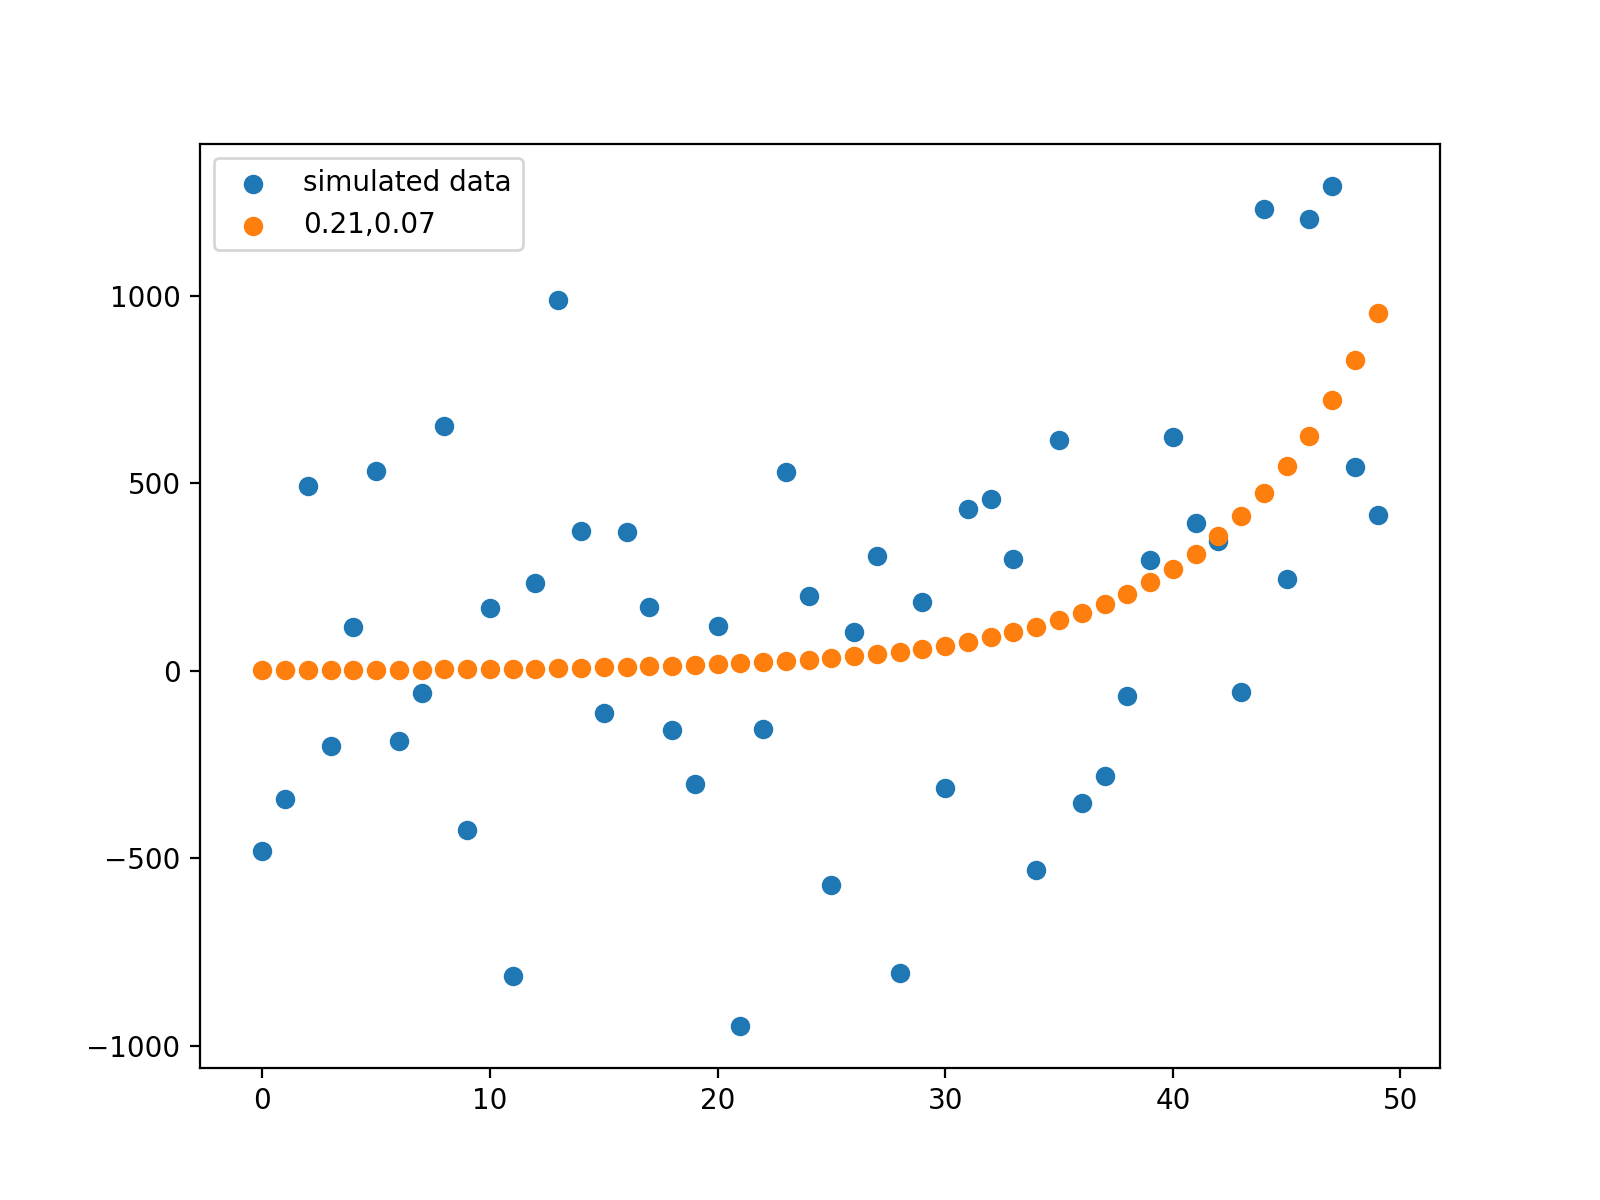

In [59]:
# Plot of data
dataI = simDataI()
steps = days
T = np.linspace(0,days-1,steps)
fig, ax = plt.subplots(1, 1, figsize=(8,6), sharex=False)
ax.scatter(T,dataI, label="simulated data")

def plotCurve(beta,gamma):
    curve = []
    for t in range(days):
        curve.append(determinedI(beta,gamma,t))
    return curve


#ax.plot(T,plotCurve(0.2,0.1),label = "0.2,0.1")
#ax.plot(T,plotCurve(0.14,0.07),label = "0.14,0.07")
ax.scatter(T,plotCurve(0.21,0.07),label = "0.21,0.07")
ax.legend(loc="best")

-6.336336666656377e+36
Highest density: -763.2729899812388
Parameters (beta,gamma) with highest density:
(0.24,0.1)


<IPython.core.display.Javascript object>


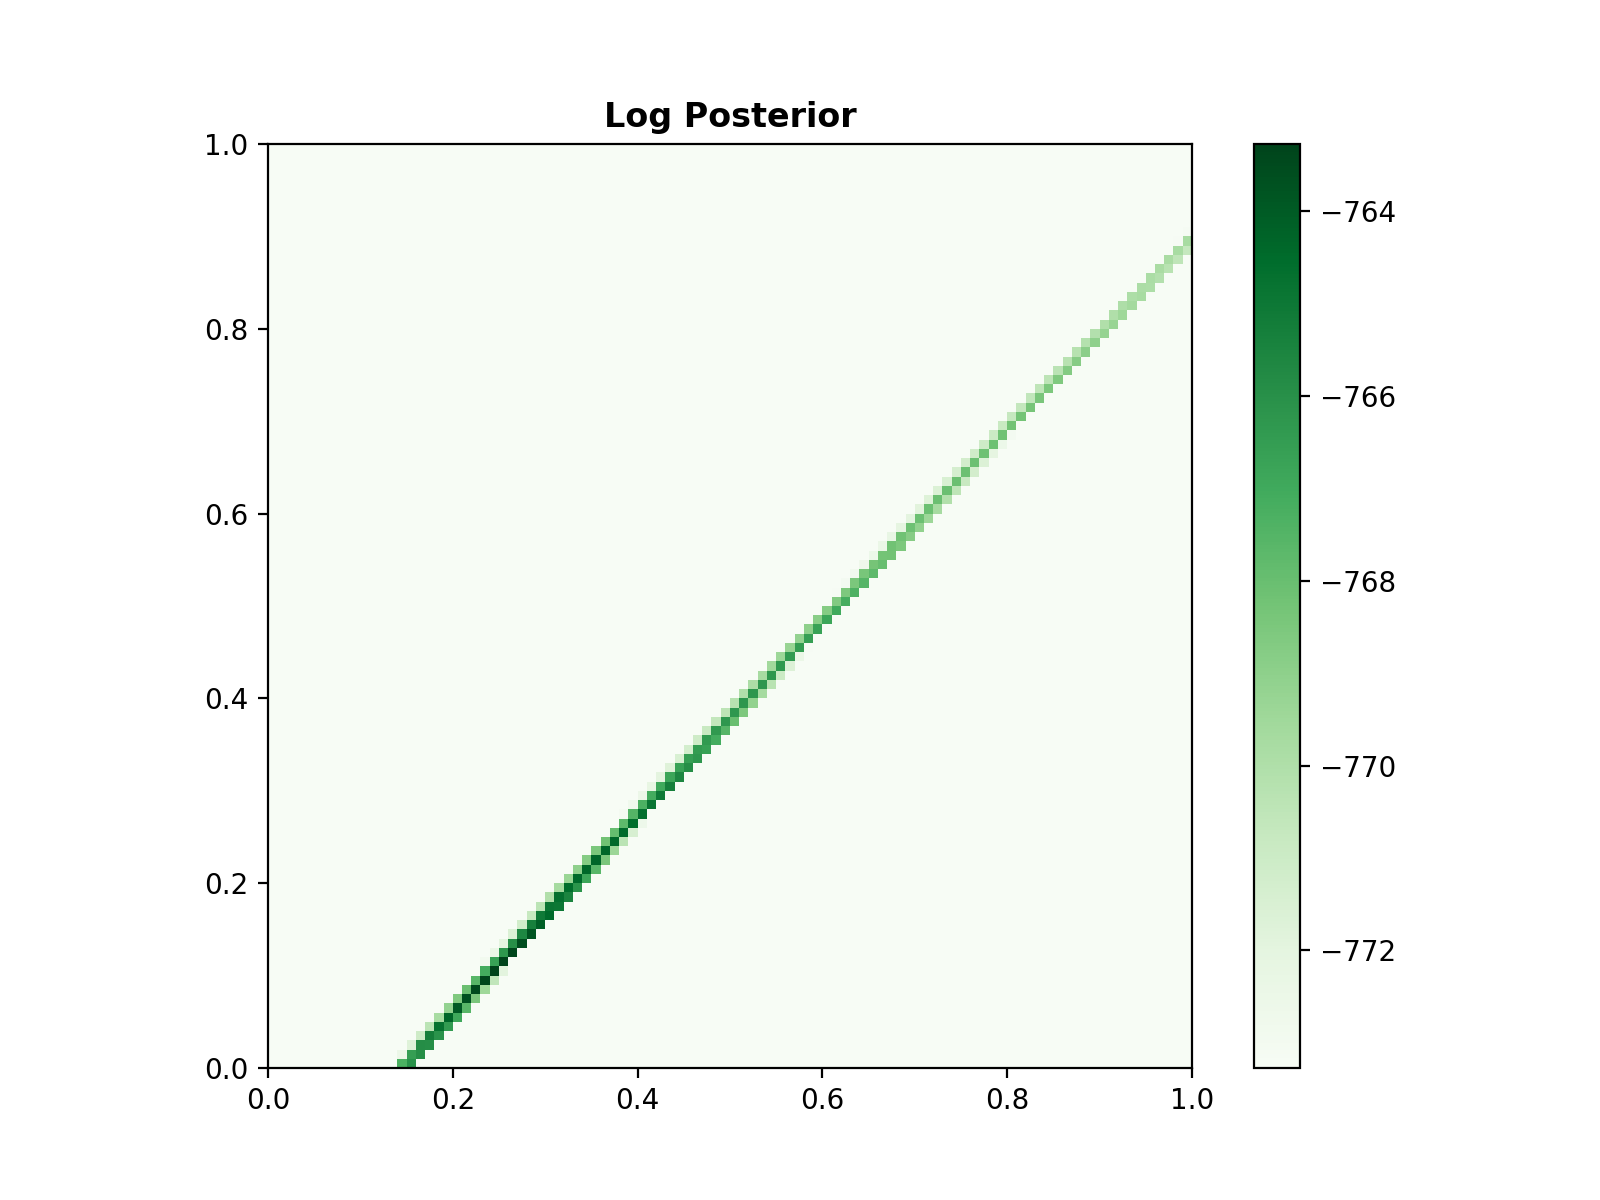

In [60]:
#Plot parameters
stepSize = 0.01
minBeta, maxBeta = 0,1
minGamma, maxGamma = 0,1

# Plot log posterior
z = logPosteriorJoint(stepSize,data,dataI)

arr = np.array(z)
z_min, z_max = np.amin(arr), np.amax(arr)
print(z_min)
print('Highest density: ' + str(np.amax(arr)))
result = np.where(arr == np.amax(arr))
print('Parameters (beta,gamma) with highest density:')
print('(' + str(result[1][0]*stepSize)+','+str(result[0][0]*stepSize)+')')

fig, bx = plt.subplots(1, 1, figsize=(8,6), sharex=False)
threshold = 10
c = bx.imshow(z, cmap ='Greens', vmin = z_max-threshold, vmax = z_max,
                 extent =[0, 1, 0, 1],
                    interpolation ='nearest', origin ='lower')
plt.colorbar(c)
  
plt.title('Log Posterior', fontweight ="bold")

plt.show()



104


<IPython.core.display.Javascript object>


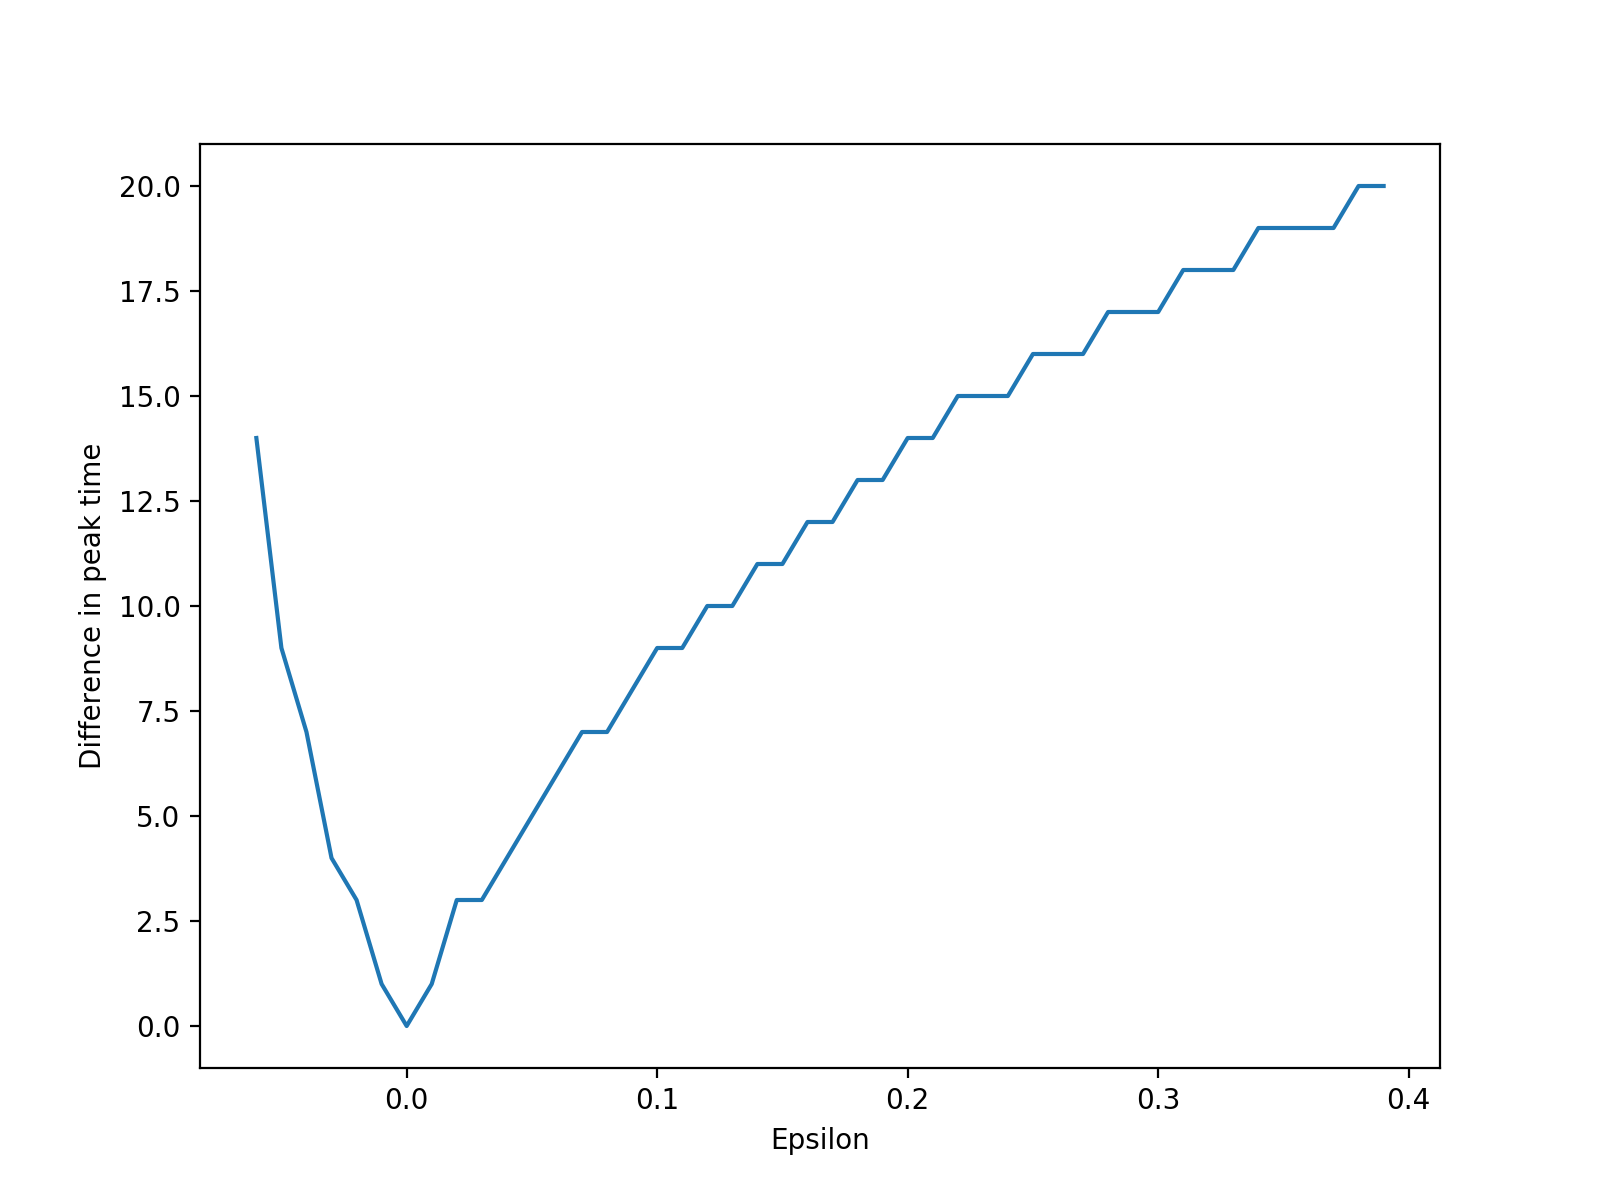

In [120]:
# The vector field V below defines the SIR ODE
def V(x,t,beta,gamma):
    return [-beta*x[0]*x[1], beta*x[0]*x[1]-gamma*x[1], gamma*x[1]]

# Population size
N = 1000000

# Initial condition; i_0 is the initial number of infected people
i_0 = 1/N
x = [1-i_0,i_0,0]

# Parameters
beta = .21
gamma = .07

# Time
days = 250
steps = 250
T = np.linspace(0,days,steps)

# Integrate (aka solve) the ODE; phi is the solution flow
phi = odeint(V, x, T, args=(beta,gamma))

# s compartment
s = phi[:,0]

# i compartment
i = phi[:,1]

# r compartment
r = phi[:,2]

t_max = np.argmax(i)

print(t_max)

#Plots
# rows = 1
# cols = 1
# fig, gx = plt.subplots(rows, cols, figsize=(8,6), sharex=False)

# T = T[:60]

# #gx.plot(T,s,label="s")
# gx.plot(T,i[:60],label="i",color="r")
# #gx.plot(T,r,label="r")
# gx.set_xlabel('Time')
# gx.set_ylabel('Proportion')
# gx.set_title('Time trajectory')
# gx.grid()
# gx.legend(loc="best")

Epsilon = np.arange(-0.06,0.4,0.01)
Dist = np.zeros(len(Epsilon))
for j in range(len(Epsilon)):
    # Solve SIR for perturbed parameter
    ep = Epsilon[j]
    beta_ep = beta + ep
    gamma_ep = gamma+ep
    phi_pert = odeint(V, x, T, args=(beta_ep, gamma_ep))
    i_pert=phi_pert[:,1]
    t_max_pert = np.argmax(i_pert)
    # Compute pointwise distance between perturbed and true trajectory
    v = np.subtract(t_max_pert,t_max)
    Dist[j] = np.abs(v)
    
fig, hx = plt.subplots(1, 1, figsize=(8,6), sharex=False)
hx.set_ylabel("Difference in peak time")
hx.set_xlabel("Epsilon")
hx.plot(Epsilon,Dist)

In [205]:
z = [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]
l = z[::2]
z2 = []
for x in l:
    z2.append(x[::2])
print(z2)

[[1, 3], [9, 11]]
